In [173]:
 !pip install torch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.5 MB/s eta 0:00:00


In [178]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import ToTensor
import torchmetrics
import torch.cuda.amp as amp
from torchvision import transforms, models

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import os
from torch_optimizer import RAdam  # Install: !pip install torch-optimizer
import torchmetrics.image

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [34]:
lr_dir = "/kaggle/input/dataset-image-super-resolution-3a/Dataset/LR" 
hr_dir = "/kaggle/input/dataset-image-super-resolution-3a/Dataset/HR"

In [35]:
def load_npy_file(filepath):
    return np.load(filepath)

def visualize_image_pairs(lr_image, hr_image, sample_name):
    # Remove singleton dimension if present (e.g., (1, H, W) -> (H, W))
    if lr_image.ndim == 3 and lr_image.shape[0] == 1:
        lr_image = lr_image[0]
    if hr_image.ndim == 3 and hr_image.shape[0] == 1:
        hr_image = hr_image[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display LR image
    axes[0].imshow(lr_image, cmap='gray')
    axes[0].set_title(f"Low Resolution - {sample_name}")
    axes[0].axis('off')
    
    # Display HR image
    axes[1].imshow(hr_image, cmap='gray')
    axes[1].set_title(f"High Resolution - {sample_name}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

Sample: sample1
LR Image Shape: (1, 75, 75), HR Image Shape: (1, 150, 150)
LR Image Min: 0.0045, Max: 0.9734
HR Image Min: 0.0000, Max: 1.0000



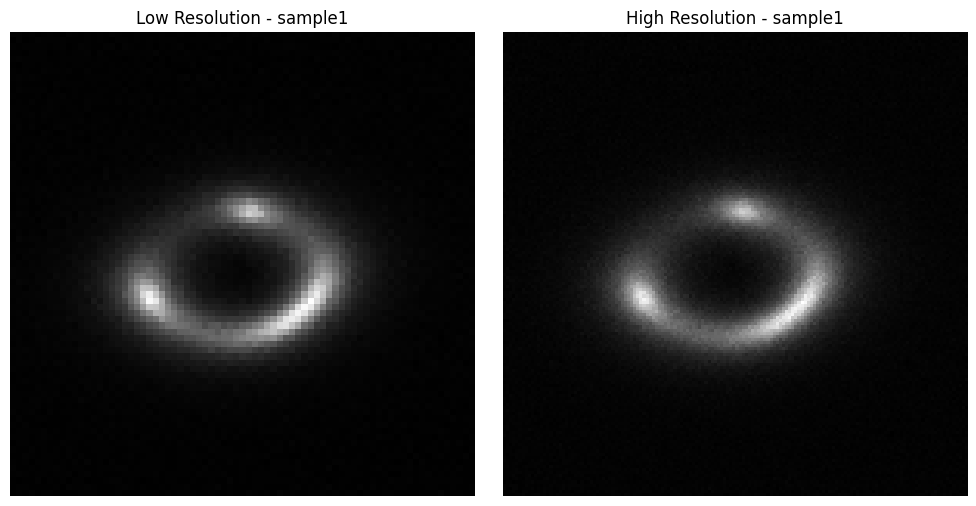

Sample: sample10
LR Image Shape: (1, 75, 75), HR Image Shape: (1, 150, 150)
LR Image Min: 0.0042, Max: 1.0184
HR Image Min: 0.0000, Max: 1.0000



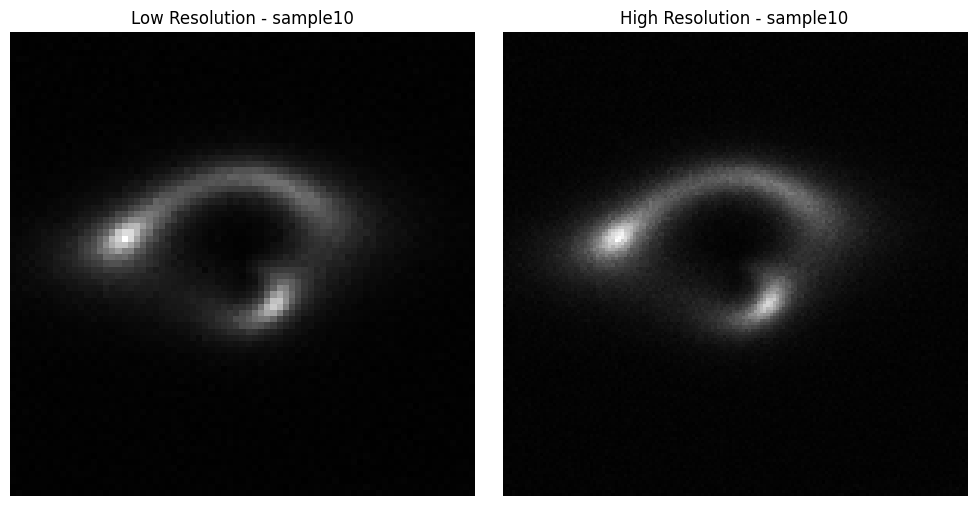

Sample: sample100
LR Image Shape: (1, 75, 75), HR Image Shape: (1, 150, 150)
LR Image Min: 0.0021, Max: 1.0088
HR Image Min: 0.0000, Max: 1.0000



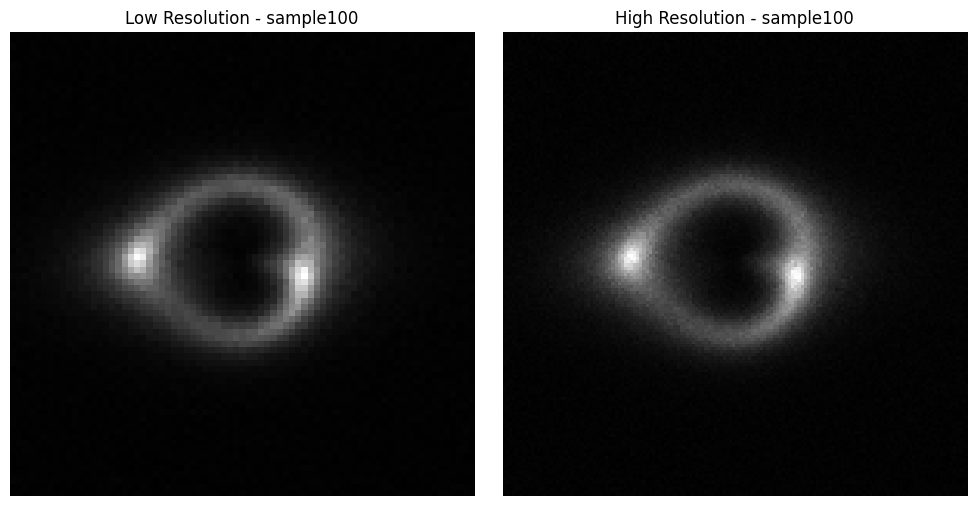

In [36]:
sample_names = ["sample1", "sample10", "sample100"]
for sample in sample_names:
    lr_path = os.path.join(lr_dir, f"{sample}.npy")
    hr_path = os.path.join(hr_dir, f"{sample}.npy")
    
    if os.path.exists(lr_path) and os.path.exists(hr_path):
        lr_image = load_npy_file(lr_path)
        hr_image = load_npy_file(hr_path)
        print(f"Sample: {sample}")
        print(f"LR Image Shape: {lr_image.shape}, HR Image Shape: {hr_image.shape}")
        print(f"LR Image Min: {lr_image.min():.4f}, Max: {lr_image.max():.4f}")
        print(f"HR Image Min: {hr_image.min():.4f}, Max: {hr_image.max():.4f}\n")
        
        visualize_image_pairs(lr_image, hr_image, sample)
    else:
        print(f"Files for {sample} not found. Check paths: {lr_path}, {hr_path}")

In [37]:
lr_files = [f for f in os.listdir(lr_dir) if f.endswith('.npy')]
hr_files = [f for f in os.listdir(hr_dir) if f.endswith('.npy')]
print(f"Total LR samples: {len(lr_files)}")
print(f"Total HR samples: {len(hr_files)}")

Total LR samples: 10000
Total HR samples: 10000


In [38]:
lr_files = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir) if f.endswith('.npy')])
hr_files = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith('.npy')])
assert len(lr_files) == len(hr_files) == 10000, "Mismatch in LR/HR files"

In [39]:
class LensingDataset(Dataset):
    def __init__(self, lr_paths, hr_paths):
        self.lr_paths = lr_paths
        self.hr_paths = hr_paths
    
    def __len__(self):
        return len(self.lr_paths)
    
    def __getitem__(self, idx):
        lr = np.load(self.lr_paths[idx]).astype(np.float32)
        hr = np.load(self.hr_paths[idx]).astype(np.float32)
        lr = np.clip(lr, 0, 1)
        hr = np.clip(hr, 0, 1)
        return torch.from_numpy(lr), torch.from_numpy(hr)

In [40]:
indices = list(range(10000))
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

In [41]:
assert len(set(train_idx) & set(val_idx)) == 0, "Train/Val overlap"
assert len(set(train_idx) & set(test_idx)) == 0, "Train/Test overlap"
assert len(set(val_idx) & set(test_idx)) == 0, "Val/Test overlap"

In [42]:
full_dataset = LensingDataset(lr_files, hr_files)
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

In [43]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [27]:
class ResBlock(nn.Module):
    def __init__(self, channels=64):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return out + 0.3 * residual  # Upped scaling

class EDSR(nn.Module):
    def __init__(self, scale_factor=2, num_blocks=8, channels=64):  # 8 blocks
        super(EDSR, self).__init__()
        self.input_conv = nn.Conv2d(1, channels, 3, padding=1, bias=False)
        self.res_blocks = nn.Sequential(*[ResBlock(channels) for _ in range(num_blocks)])
        self.mid_conv = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.upsample = nn.Sequential(
            nn.Conv2d(channels, channels*4, 3, padding=1, bias=False),
            nn.PixelShuffle(2)
        )
        self.output_conv = nn.Conv2d(channels, 1, 3, padding=1, bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
    
    def forward(self, x):
        x = self.input_conv(x)
        residual = x
        x = self.res_blocks(x)
        x = self.mid_conv(x) + 0.3 * residual
        x = self.upsample(x)
        x = self.output_conv(x)
        return torch.clamp(x, 0, 1)

In [15]:
def train(model, train_loader, val_loader, epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decay faster
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    
    lr, hr = next(iter(train_loader))
    print(f"LR shape: {lr.shape}, HR shape: {hr.shape}")
    with torch.no_grad():
        sr = model(lr.to(device))
        print(f"SR shape: {sr.shape}, SR min: {sr.min().item():.4f}, max: {sr.max().item():.4f}")
        plt.imshow(sr[0, 0].cpu().numpy(), cmap="gray")
        plt.savefig("debug_sr_epoch0.png")
        plt.close()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for lr, hr in train_loader:
            lr, hr = lr.to(device), hr.to(device)
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * lr.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for lr, hr in val_loader:
                lr, hr = lr.to(device), hr.to(device)
                sr = model(lr)
                loss = criterion(sr, hr)
                val_loss += loss.item() * lr.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if (epoch + 1) % 5 == 0:
            with torch.no_grad():
                sr = model(lr.to(device))
                print(f"Epoch {epoch+1} SR min: {sr.min().item():.4f}, max: {sr.max().item():.4f}")
                plt.imshow(sr[0, 0].cpu().numpy(), cmap="gray")
                plt.savefig(f"debug_sr_epoch{epoch+1}.png")
                plt.close()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "edsr_best.pth")
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("L1 Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid()
    plt.savefig("loss_curves.png")
    plt.close()
    
    return model

In [17]:
model = EDSR(scale_factor=2, num_blocks=8, channels=64)
trained_model = train(model, train_loader, val_loader, epochs=30)

LR shape: torch.Size([32, 1, 75, 75]), HR shape: torch.Size([32, 1, 150, 150])
SR shape: torch.Size([32, 1, 150, 150]), SR min: 0.0000, max: 0.0897
Epoch 1/30, Train Loss: 0.0211, Val Loss: 0.0191
Epoch 2/30, Train Loss: 0.0191, Val Loss: 0.0190
Epoch 3/30, Train Loss: 0.0190, Val Loss: 0.0189
Epoch 4/30, Train Loss: 0.0190, Val Loss: 0.0190
Epoch 5/30, Train Loss: 0.0190, Val Loss: 0.0189
Epoch 5 SR min: 0.0000, max: 0.9807
Epoch 6/30, Train Loss: 0.0152, Val Loss: 0.0051
Epoch 7/30, Train Loss: 0.0050, Val Loss: 0.0049
Epoch 8/30, Train Loss: 0.0049, Val Loss: 0.0049
Epoch 9/30, Train Loss: 0.0049, Val Loss: 0.0049
Epoch 10/30, Train Loss: 0.0049, Val Loss: 0.0049
Epoch 10 SR min: 0.0038, max: 0.9855
Epoch 11/30, Train Loss: 0.0049, Val Loss: 0.0049
Epoch 12/30, Train Loss: 0.0049, Val Loss: 0.0049
Epoch 13/30, Train Loss: 0.0049, Val Loss: 0.0049
Epoch 14/30, Train Loss: 0.0049, Val Loss: 0.0049
Epoch 15/30, Train Loss: 0.0049, Val Loss: 0.0049
Epoch 15 SR min: 0.0037, max: 0.9851
E

In [34]:
evaluate_split(trained_model, train_loader, "Train", num_vis=3)
evaluate_split(trained_model, val_loader, "Val", num_vis=3)
evaluate_split(trained_model, test_loader, "Test", num_vis=3)

Train MSE: 0.0001, SSIM: 0.9760, PSNR: 42.3238
Val MSE: 0.0001, SSIM: 0.9760, PSNR: 42.3500
Test MSE: 0.0001, SSIM: 0.9759, PSNR: 42.3159


In [23]:
torch.save(trained_model.state_dict(), "edsr_final_30epochs.pth")
print("Saved final 30-epoch model as edsr_final_30epochs.pth")

Saved final 30-epoch model as edsr_final_30epochs.pth
